In [2]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [3]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )

    #count missing values in X
    missing_values_count = X.isnull().sum().sum()
    print(f"Missing values in X: {missing_values_count}")

    X = np.array(X)
    y = np.array(y)[..., None]
    print(X.shape)
    print(y.shape)
    
    # Determine if the dataset has categorical features
    has_categorical = any(categorical_indicator)
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
        'has_categorical': has_categorical,
        'n_missing_values': missing_values_count,
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
df_metadata.sort_values('%_unique_y', ascending=True)

# Display the metadata DataFrame
df_metadata.loc[44962, "has_categorical"] = True
df_metadata

Missing values in X: 0
(4177, 8)
(4177, 1)
 1/35 Processed dataset 44956: abalone
Missing values in X: 0
(1503, 5)
(1503, 1)
 2/35 Processed dataset 44957: airfoil_self_noise
Missing values in X: 0
(2043, 7)
(2043, 1)
 3/35 Processed dataset 44958: auction_verification
Missing values in X: 0
(1030, 8)
(1030, 1)
 4/35 Processed dataset 44959: concrete_compressive_strength
Missing values in X: 0
(45730, 9)
(45730, 1)
 5/35 Processed dataset 44963: physiochemical_protein
Missing values in X: 0
(21263, 81)
(21263, 1)
 6/35 Processed dataset 44964: superconductivity
Missing values in X: 0
(1059, 116)
(1059, 1)
 7/35 Processed dataset 44965: geographical_origin_of_music
Missing values in X: 0
(1066, 10)
(1066, 1)
 8/35 Processed dataset 44966: solar_flare
Missing values in X: 0
(11934, 14)
(11934, 1)
 9/35 Processed dataset 44969: naval_propulsion_plant
Missing values in X: 0
(4898, 11)
(4898, 1)
 10/35 Processed dataset 44971: white_wine
Missing values in X: 0
(1599, 11)
(1599, 1)
 11/35 Pr

,name,n_obs,n_features,%_unique_y,n_unique_y,has_categorical,n_missing_values
dataset_id,,,,,,,
41021,Moneyball,1232,15,0.303571,374,True,3600
44956,abalone,4177,9,0.006703,28,True,0
44957,airfoil_self_noise,1503,6,0.968729,1456,False,0
44958,auction_verification,2043,8,0.998042,2039,True,0
44959,concrete_compressive_strength,1030,9,0.910680,938,False,0
44960,energy_efficiency,768,9,0.764323,587,False,0
44962,forest_fires,517,13,0.485493,251,True,0
44963,physiochemical_protein,45730,10,0.347759,15903,False,0
44964,superconductivity,21263,82,0.141419,3007,False,0


In [4]:
dataset_ids_no_categorical = list(df_metadata.query("has_categorical == False").index.values)
dataset_ids_no_categorical = sorted([int(x) for x in dataset_ids_no_categorical])
len(dataset_ids_no_categorical)
dataset_ids_no_categorical

[44957,
 44959,
 44960,
 44963,
 44964,
 44965,
 44969,
 44970,
 44971,
 44972,
 44973,
 44975,
 44976,
 44977,
 44978,
 44980,
 44981,
 44983,
 44994,
 45402]

# Run experiments (just for testing)

In [ ]:
# run_all_openML_with_model(
#     dataset_ids_no_categorical[0:2], 
#     evaluate_Ridge,
#     name_model="Ridge",
#     k_folds=5,
#     cv_seed=42,
#     regression_or_classification="regression",
#     n_optuna_trials=2,
#     device="cuda",
#     save_dir = "/home/nikita/Code/zephyrox/pytorch_based/SWIM/save/"
# )

-- models:::: End2End Ridge RidgeCV XGBoostRegressor GradientRFBoost GradientRFBoostID GreedyRFBoostDense GreedyRFBoostDiag GreedyRFBoostScalar


In [ ]:
!python regression_param_specs.py --models End2End --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 50 --device cuda --k_folds 5 --cv_seed 42 --save_experiments_individually

In [4]:
!python regression_param_specs.py --models Ridge --dataset_indices 0  --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 100 --device cuda --k_folds 5 --cv_seed 42

[I 2024-12-03 15:46:24,461] A new study created in memory with name: no-name-eebfd058-ec72-4b81-8d14-32232fdd499a
[I 2024-12-03 15:46:24,468] Trial 0 finished with value: 0.6950939774513245 and parameters: {'l2_reg': 1.713594813287429e-05}. Best is trial 0 with value: 0.6950939774513245.
[I 2024-12-03 15:46:24,473] Trial 1 finished with value: 0.695086145401001 and parameters: {'l2_reg': 0.0008852577040573714}. Best is trial 1 with value: 0.695086145401001.
[I 2024-12-03 15:46:24,478] Trial 2 finished with value: 0.6966134190559388 and parameters: {'l2_reg': 0.04098557077370728}. Best is trial 1 with value: 0.695086145401001.
[I 2024-12-03 15:46:24,483] Trial 3 finished with value: 0.6950788140296936 and parameters: {'l2_reg': 0.002088303591650141}. Best is trial 3 with value: 0.6950788140296936.
[I 2024-12-03 15:46:24,488] Trial 4 finished with value: 0.6950769305229187 and parameters: {'l2_reg': 0.004780524312709461}. Best is trial 4 with value: 0.6950769305229187.
[I 2024-12-03 15:4

In [ ]:
!python regression_param_specs.py --models RidgeCV --dataset_indices 17 18 19  --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 100 --device cuda --k_folds 5 --cv_seed 42

[I 2024-12-02 20:50:48,435] A new study created in memory with name: no-name-674f959a-9fde-473e-b2fd-8f2f38c81b92
[I 2024-12-02 20:50:48,446] Trial 0 finished with value: 0.4133633732795715 and parameters: {'l2_reg': 0.0017053709204126154}. Best is trial 0 with value: 0.4133633732795715.
[I 2024-12-02 20:50:48,454] Trial 1 finished with value: 0.4133248865604401 and parameters: {'l2_reg': 2.0638495199064525e-05}. Best is trial 1 with value: 0.4133248865604401.
[I 2024-12-02 20:50:48,462] Trial 2 finished with value: 0.41373313069343565 and parameters: {'l2_reg': 0.0064613987690671825}. Best is trial 1 with value: 0.4133248865604401.
[I 2024-12-02 20:50:48,470] Trial 3 finished with value: 0.41357163786888124 and parameters: {'l2_reg': 0.004677157441922423}. Best is trial 1 with value: 0.4133248865604401.
[I 2024-12-02 20:50:48,481] Trial 4 finished with value: 0.4133392870426178 and parameters: {'l2_reg': 0.0011036183131687177}. Best is trial 1 with value: 0.4133248865604401.
[I 2024-1

In [ ]:
!python regression_param_specs.py --models XGBoostRegressor --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 1 --device cpu --k_folds 2 --cv_seed 42 --save_experiments_individually

In [ ]:
!python regression_param_specs.py --models GradientRFBoost --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 100 --device cuda --k_folds 5 --cv_seed 42 --save_experiments_individually

In [ ]:
!python regression_param_specs.py --models GradientRFBoostID --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 1 --device cuda --k_folds 2 --cv_seed 42 --save_experiments_individually

In [ ]:
!python regression_param_specs.py --models GreedyRFBoostDense --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 100 --device gpu --k_folds 5 --cv_seed 42 --save_experiments_individually

In [ ]:
!python regression_param_specs.py --models GreedyRFBoostDiag --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 1 --device cuda --k_folds 2 --cv_seed 42 --save_experiments_individually

In [ ]:
!python regression_param_specs.py --models GreedyRFBoostScalar --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ --n_optuna_trials 1 --device cuda --k_folds 2 --cv_seed 42 --save_experiments_individually

# join json results

In [20]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids_noCat


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,      13,14,15,16,17,18,19]],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs

df = results_to_df()

In [23]:
df["score_test"].mean().sort_values(ascending=True)

XGBoostRegressor       0.389427
End2End                0.408184
GreedyRFBoostDense      0.43249
GradientRFBoost        0.434696
GradientRFBoostID      0.436364
GreedyRFBoostDiag      0.445675
GreedyRFBoostScalar    0.528314
Ridge                  0.606384
RidgeCV                0.606385
dtype: object

In [15]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor       0.170585
End2End                0.345058
GreedyRFBoostDense     0.387421
GradientRFBoost        0.400575
GradientRFBoostID      0.405132
GreedyRFBoostDiag       0.41455
GreedyRFBoostScalar    0.510962
RidgeCV                0.600331
Ridge                   0.60034
dtype: object

In [17]:
df["score_test"].rank(axis=1).mean().sort_values()

XGBoostRegressor       2.666667
End2End                3.333333
GreedyRFBoostDense     3.500000
GradientRFBoost        3.611111
GradientRFBoostID      4.111111
GreedyRFBoostDiag      4.777778
GreedyRFBoostScalar    6.722222
Ridge                  8.055556
RidgeCV                8.222222
dtype: float64

# Look at distribution of params

Model: End2End


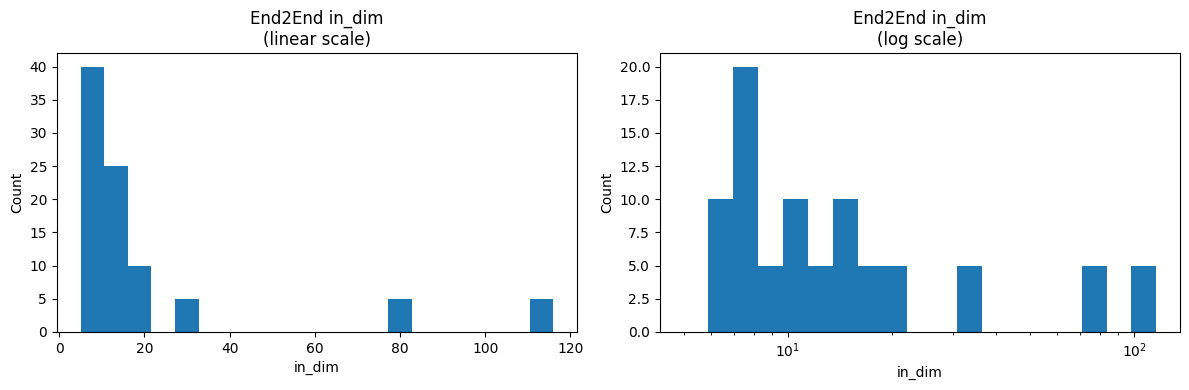

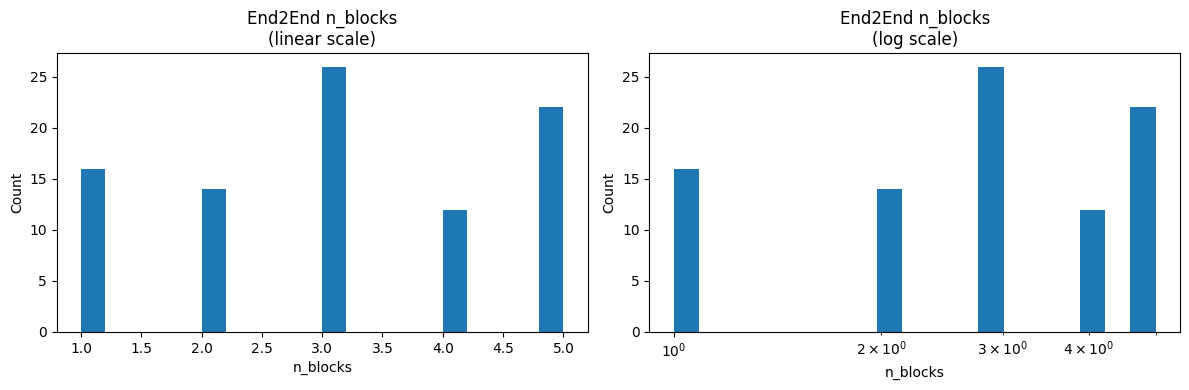

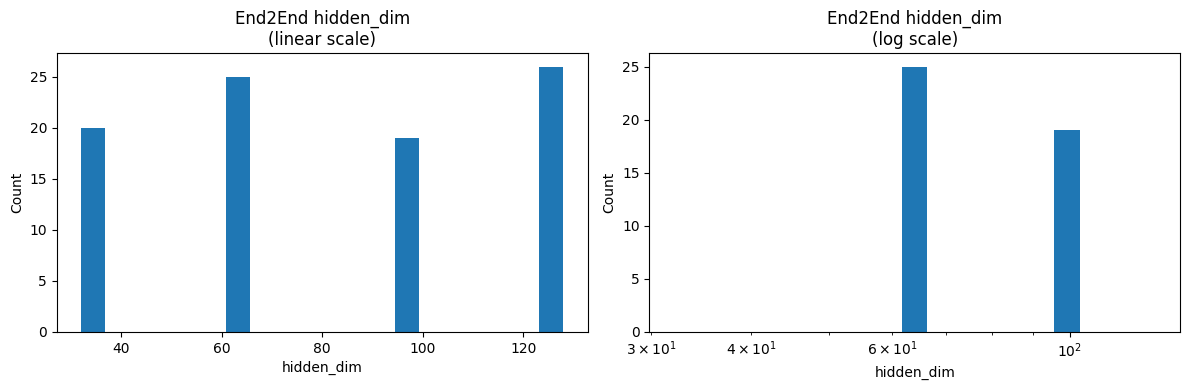

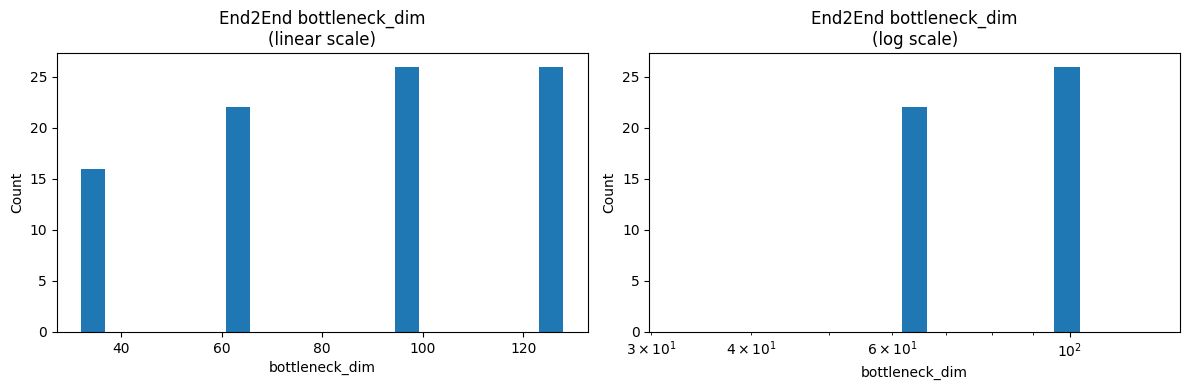

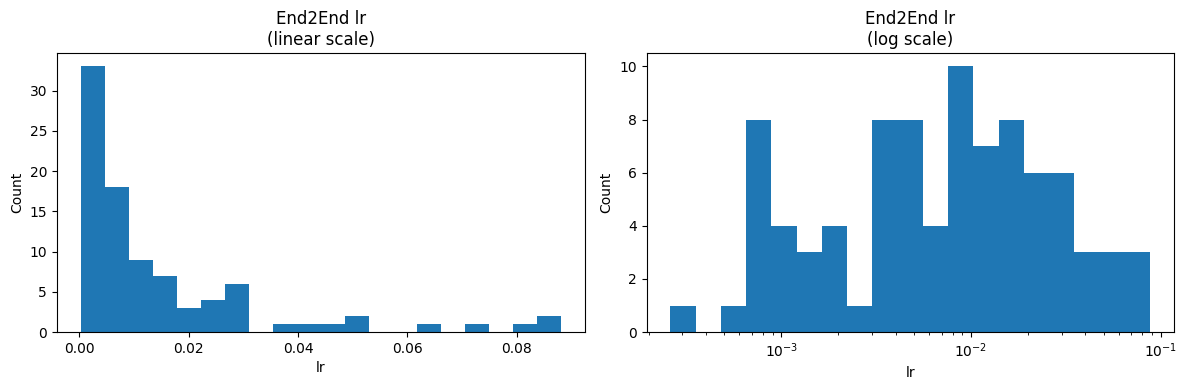

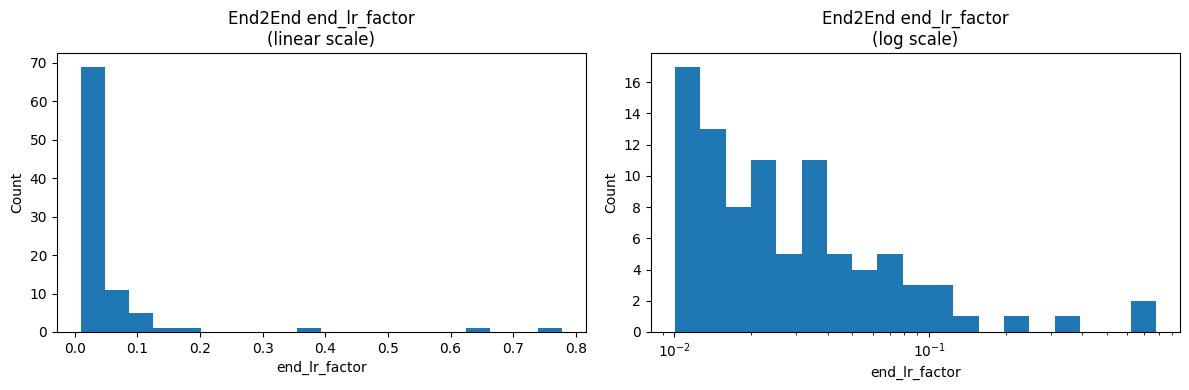

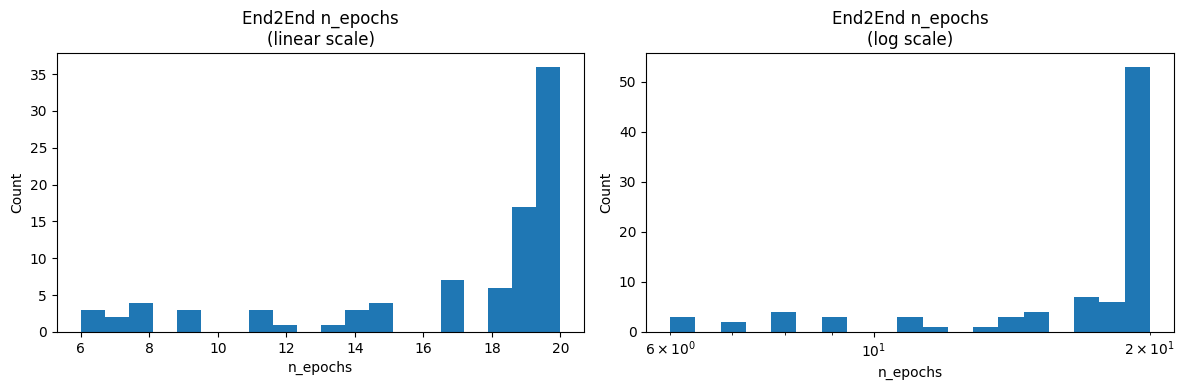

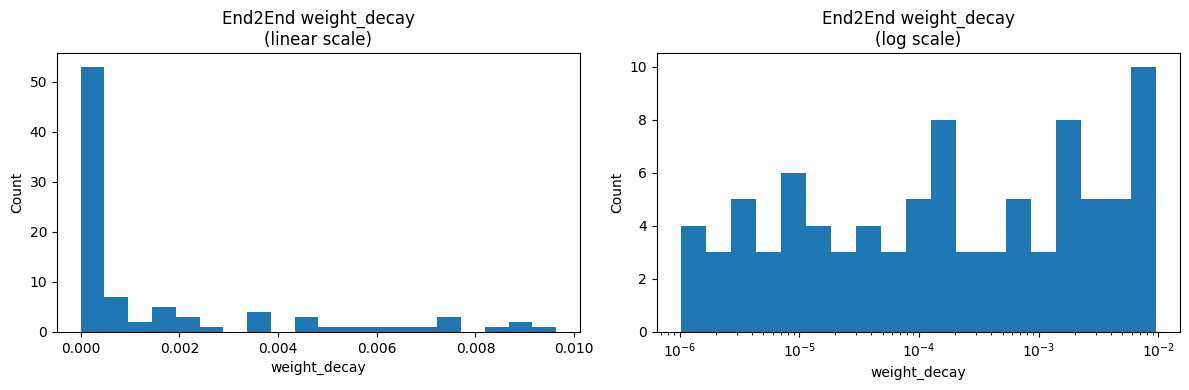

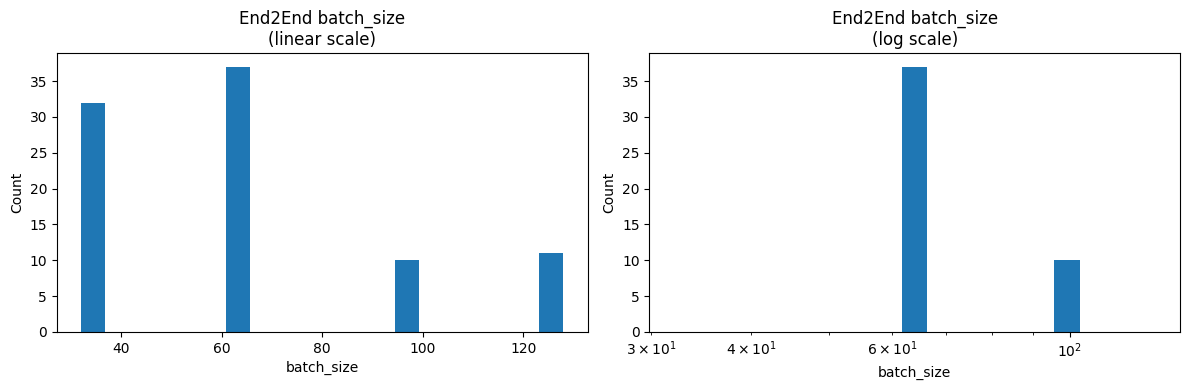

Model: Ridge


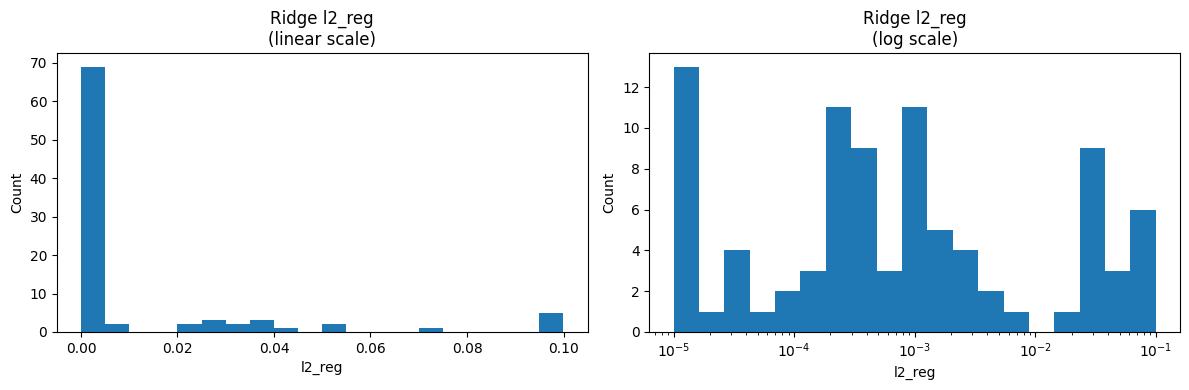

Model: RidgeCV


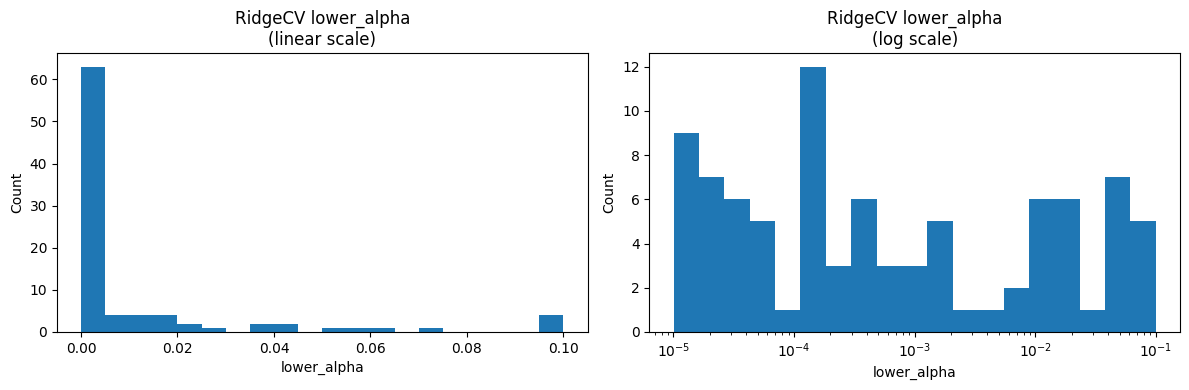

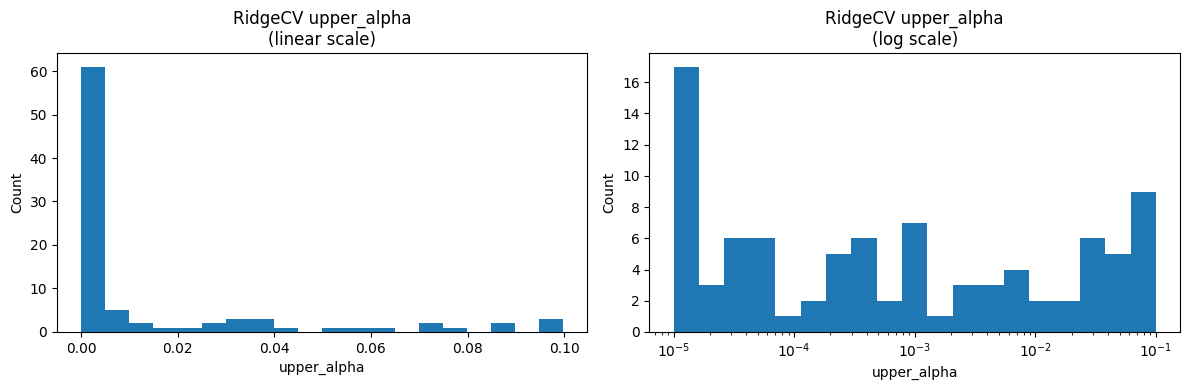

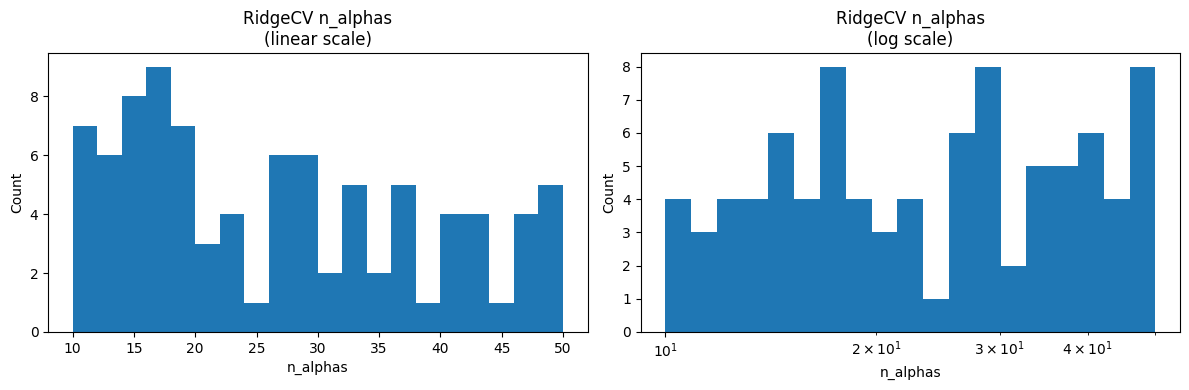

Model: XGBoostRegressor


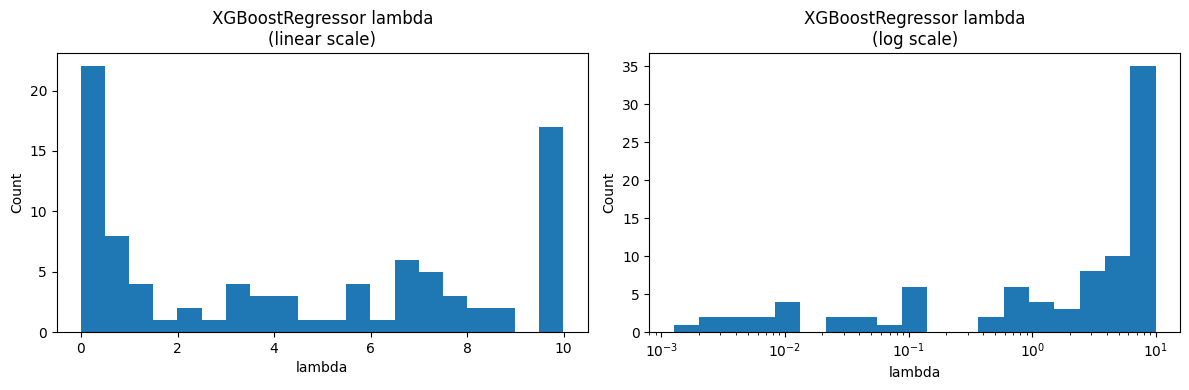

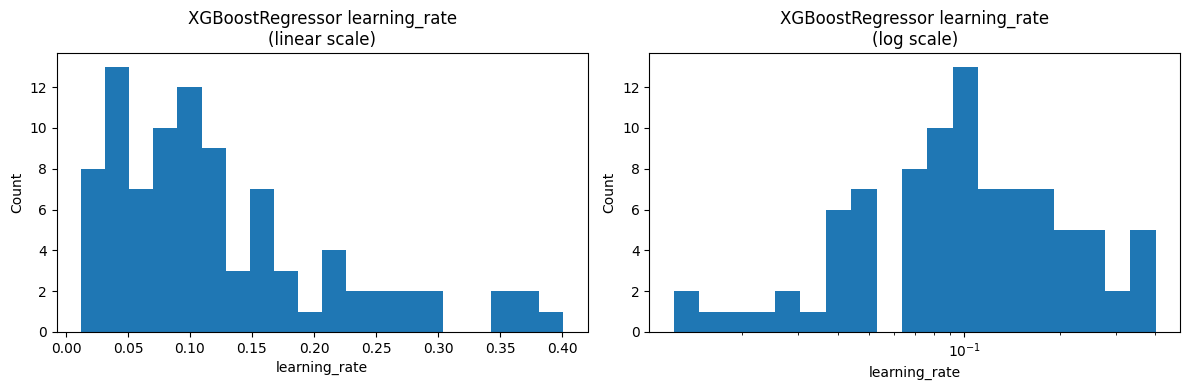

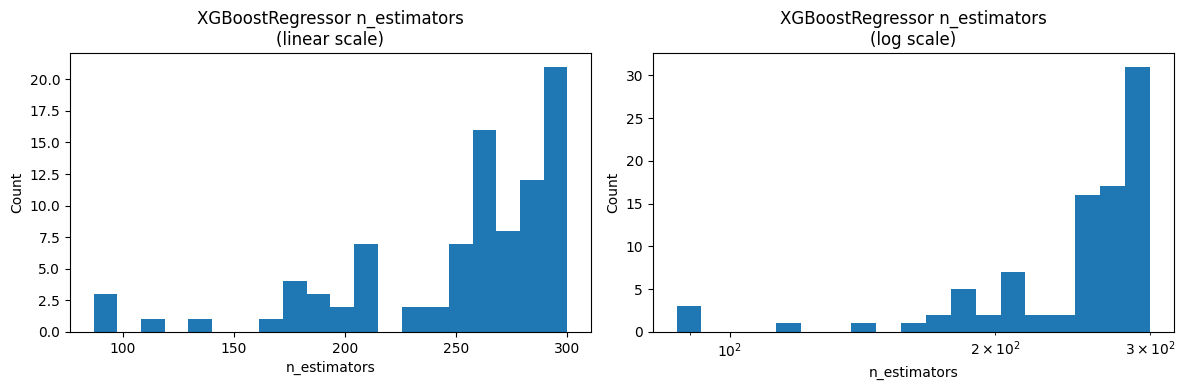

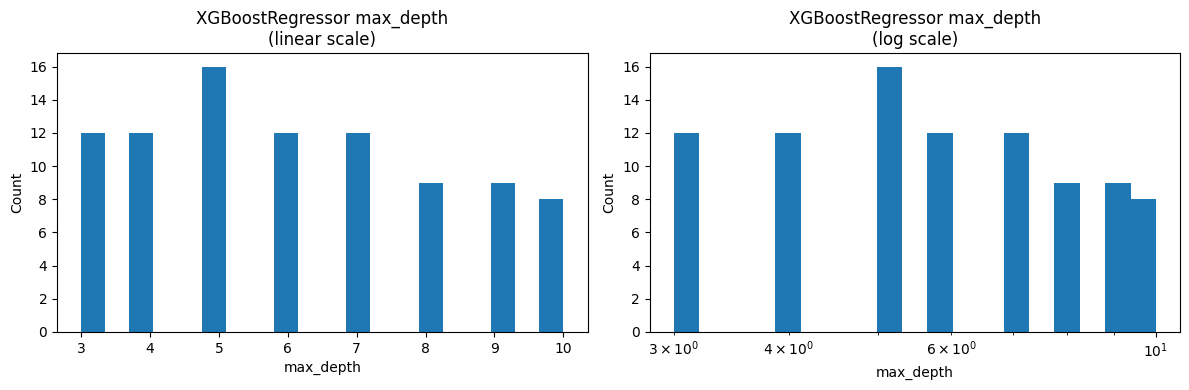

Model: GradientRFBoost


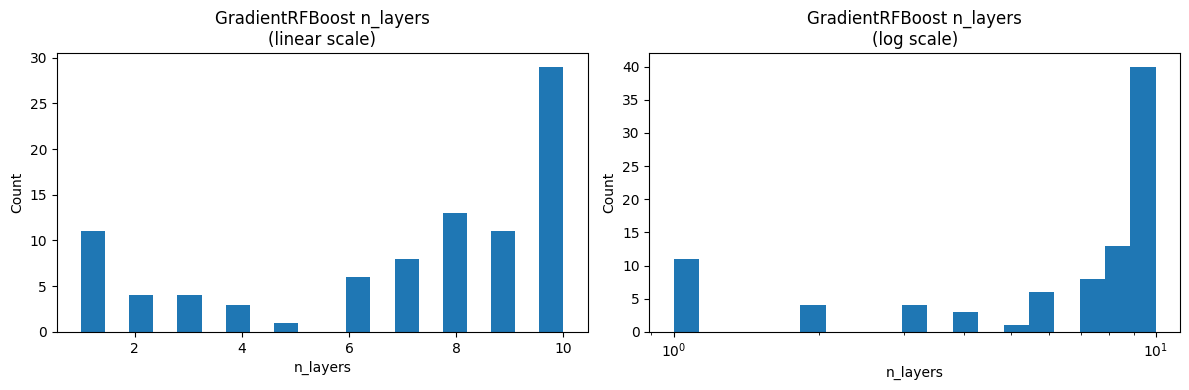

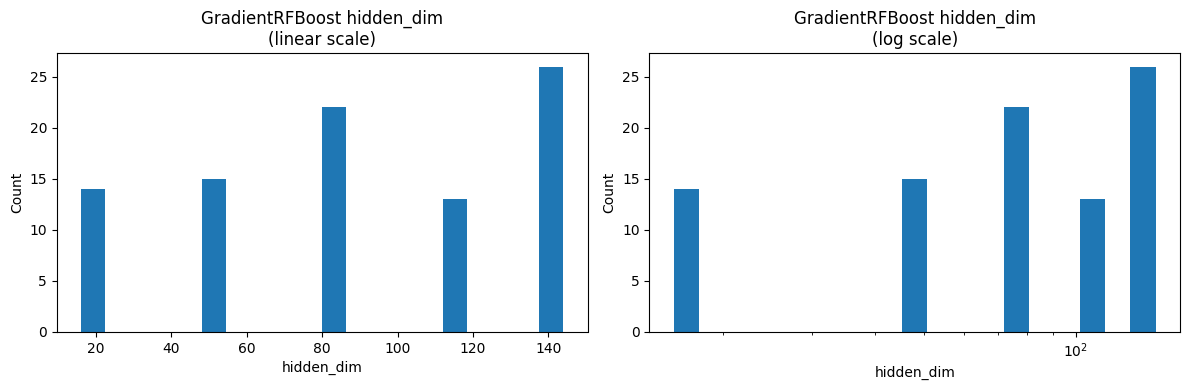

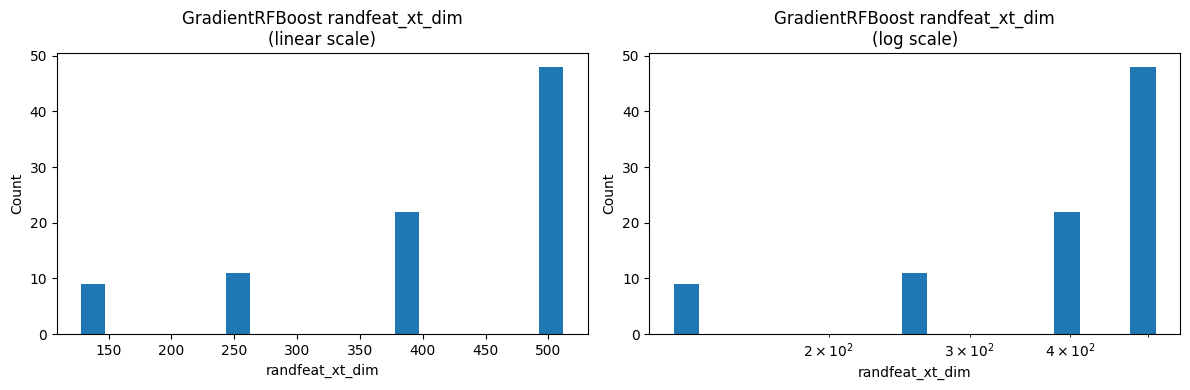

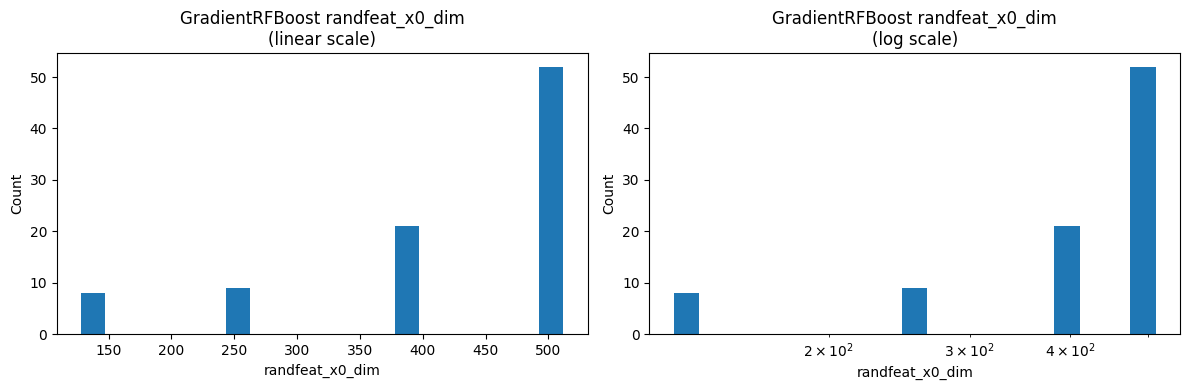

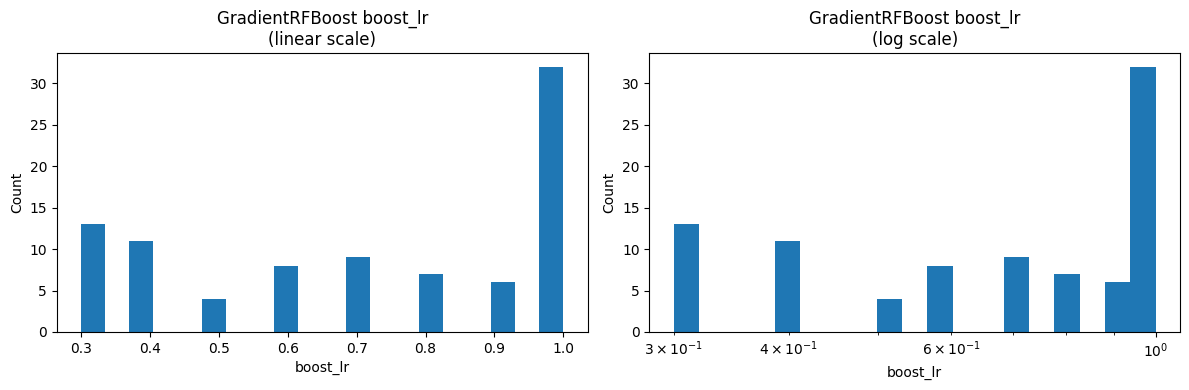

Model: GradientRFBoostID


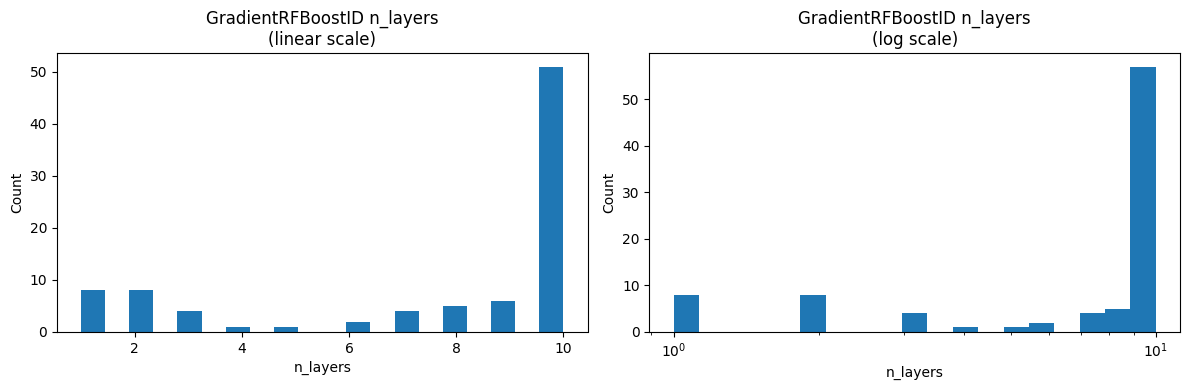

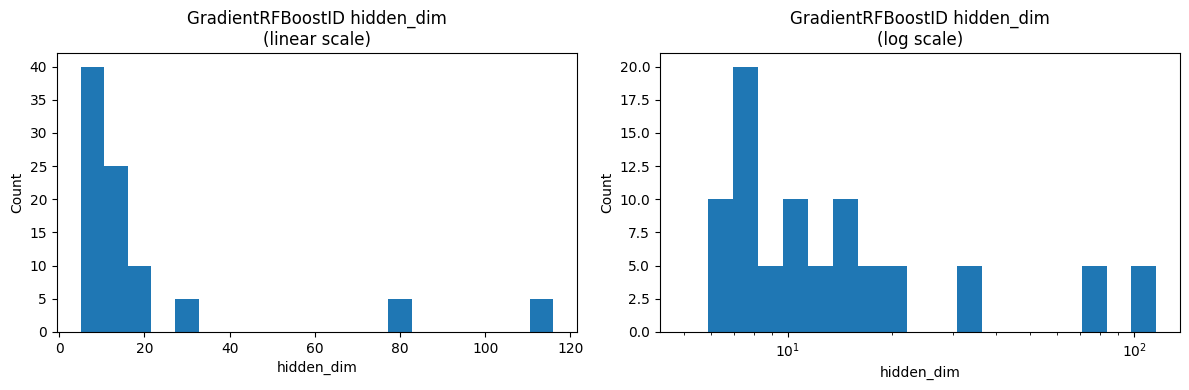

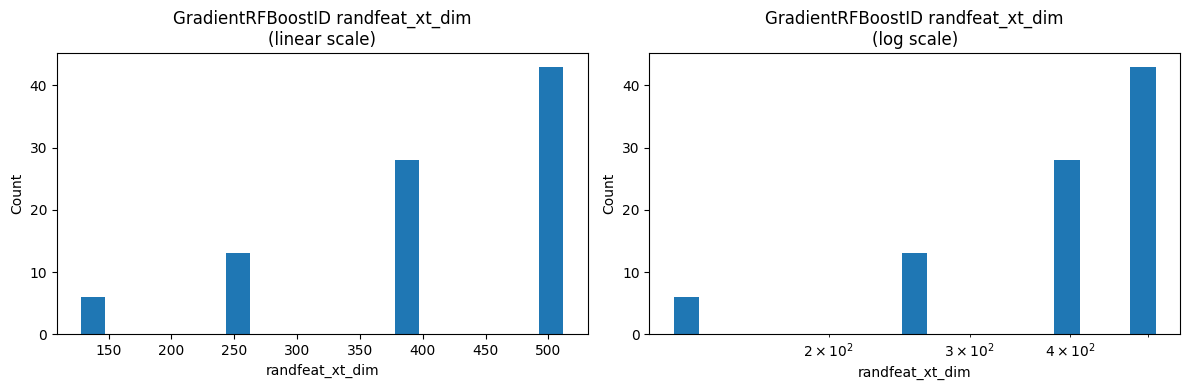

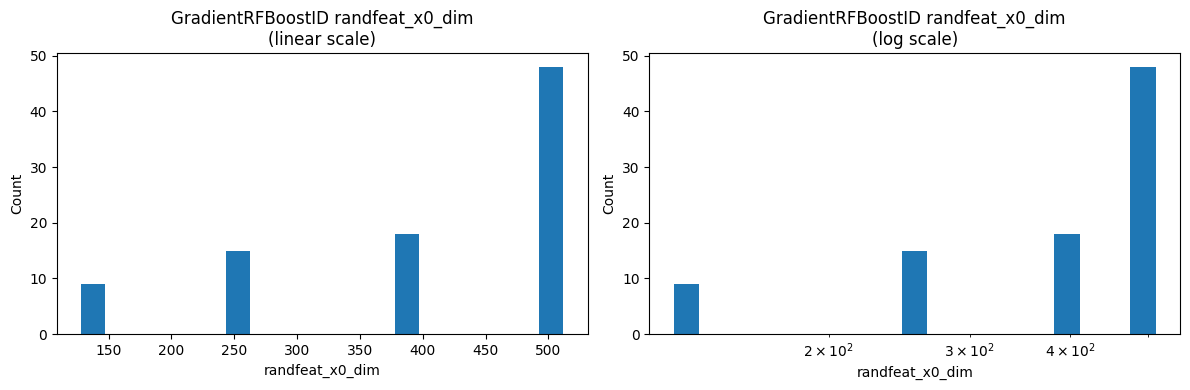

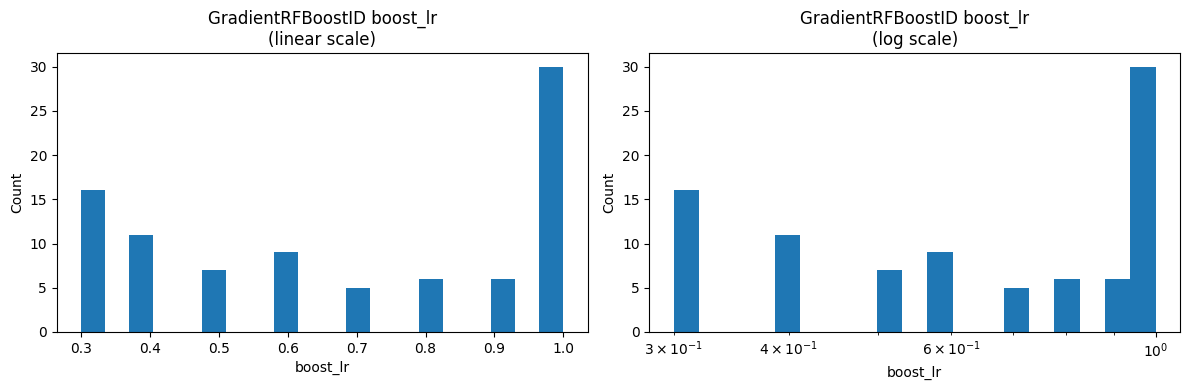

Model: GreedyRFBoostDense


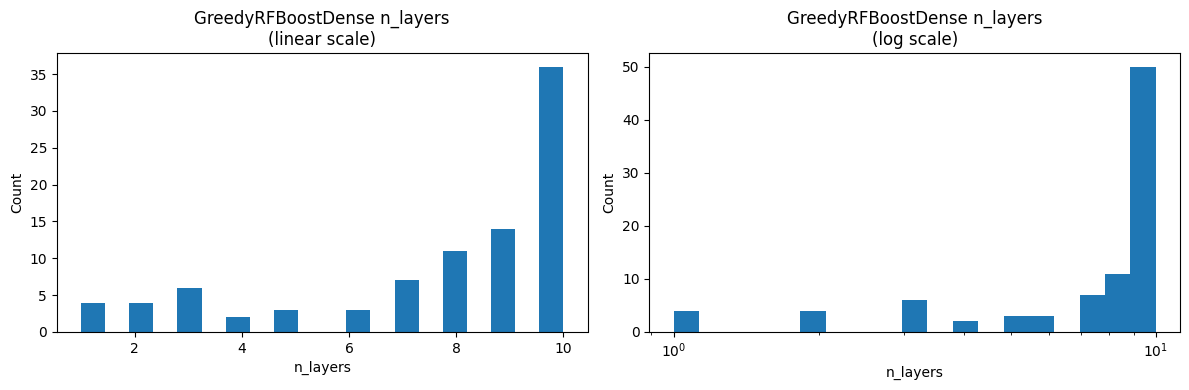

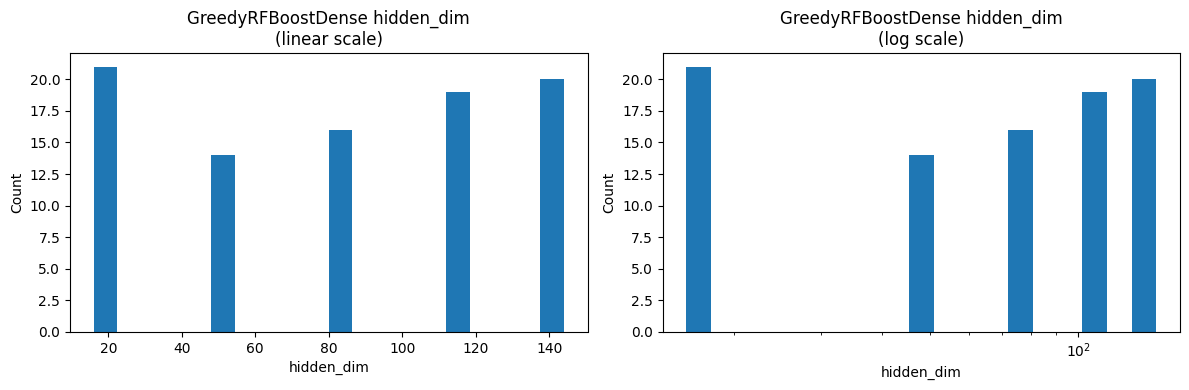

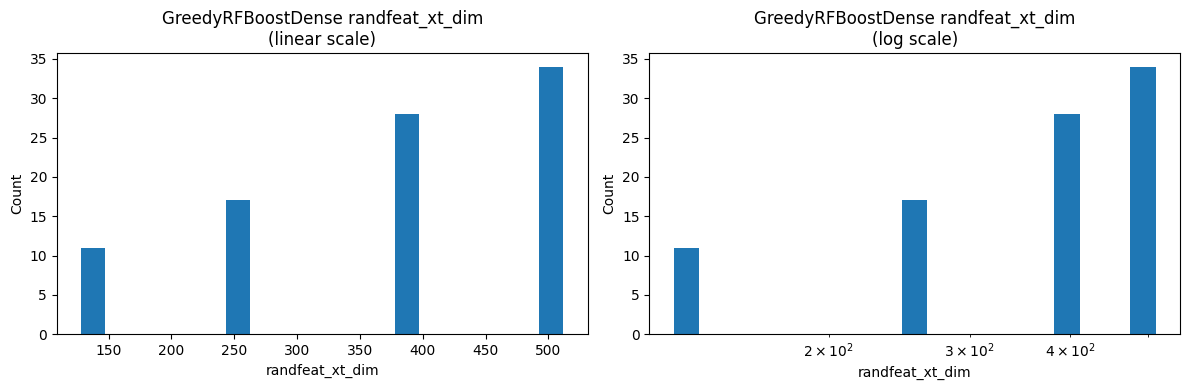

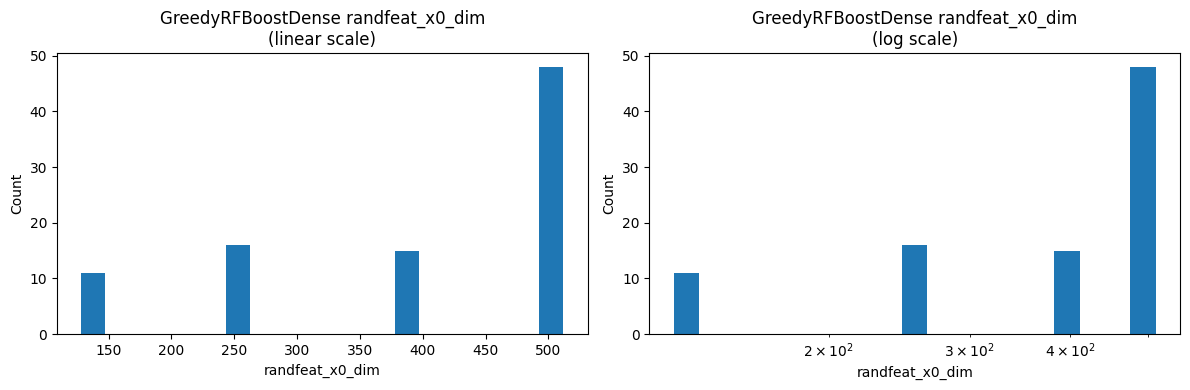

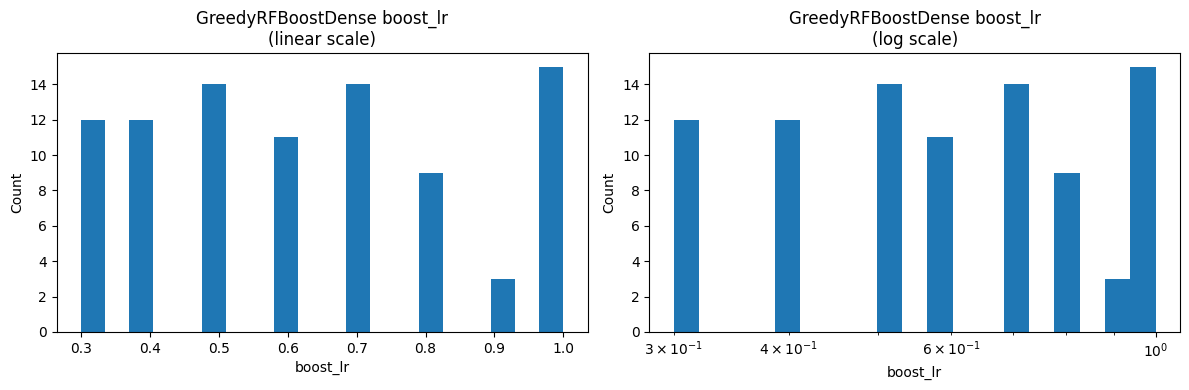

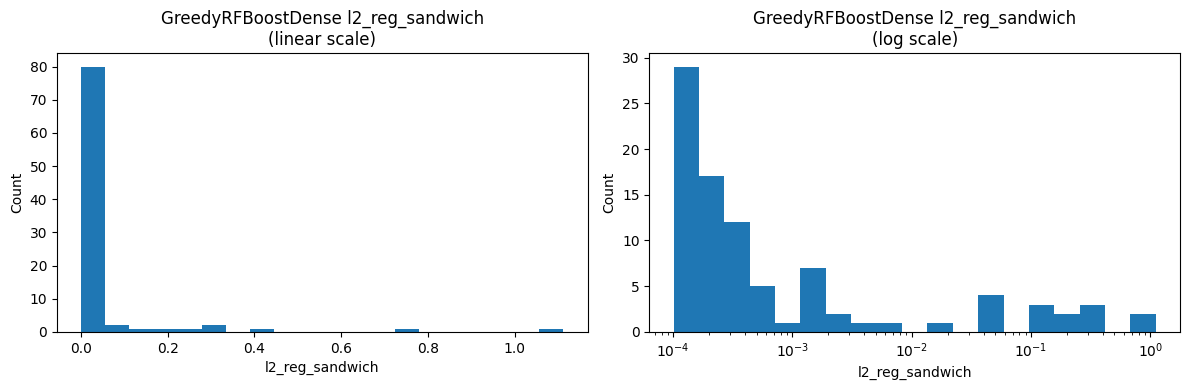

Model: GreedyRFBoostDiag


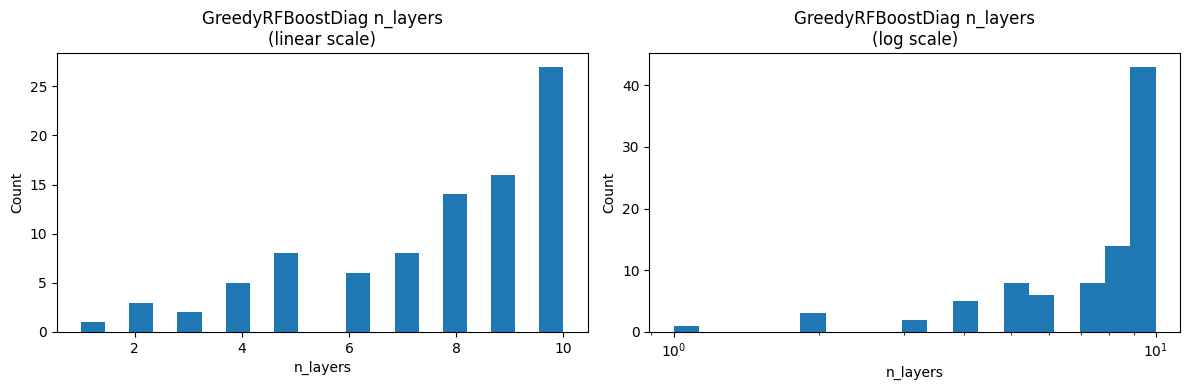

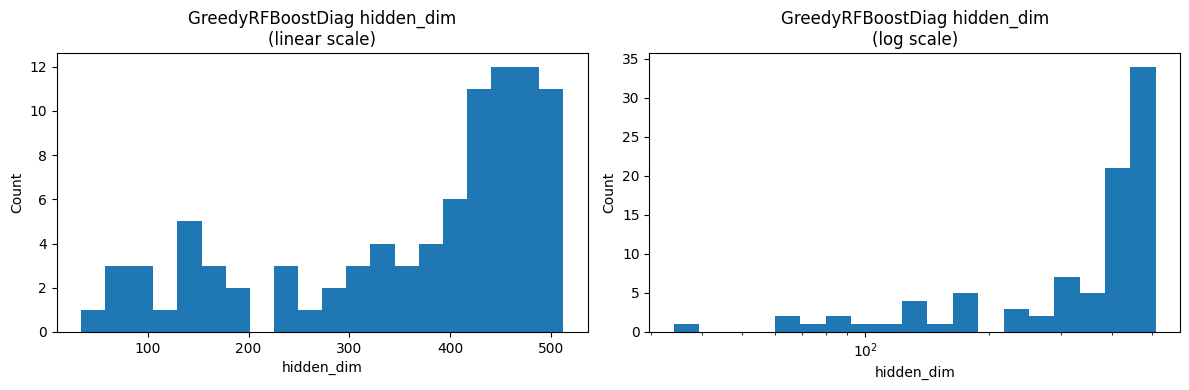

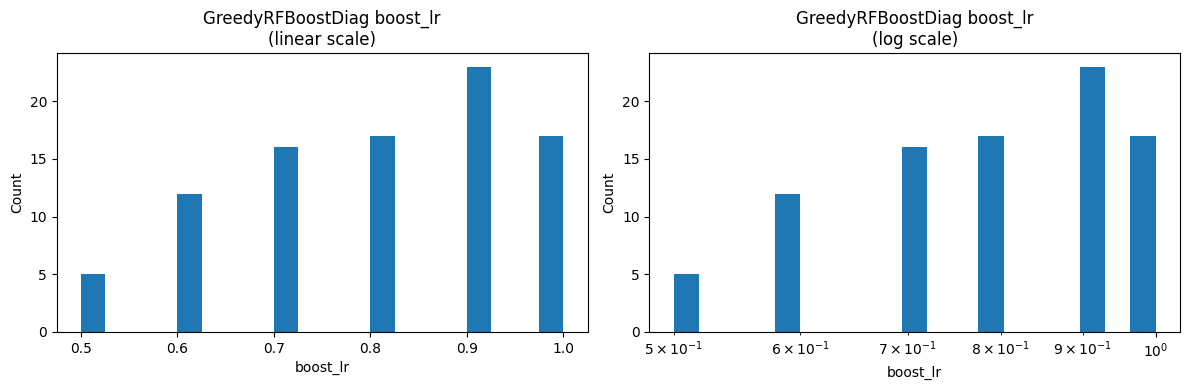

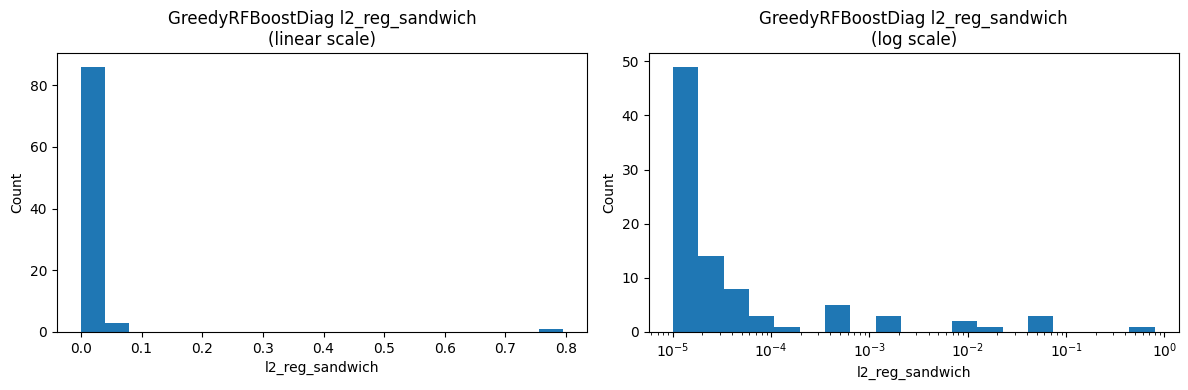

Model: GreedyRFBoostScalar


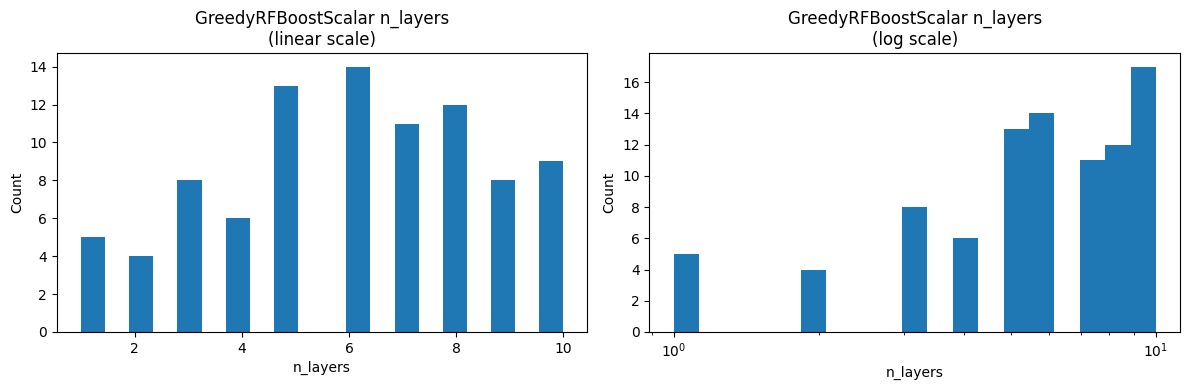

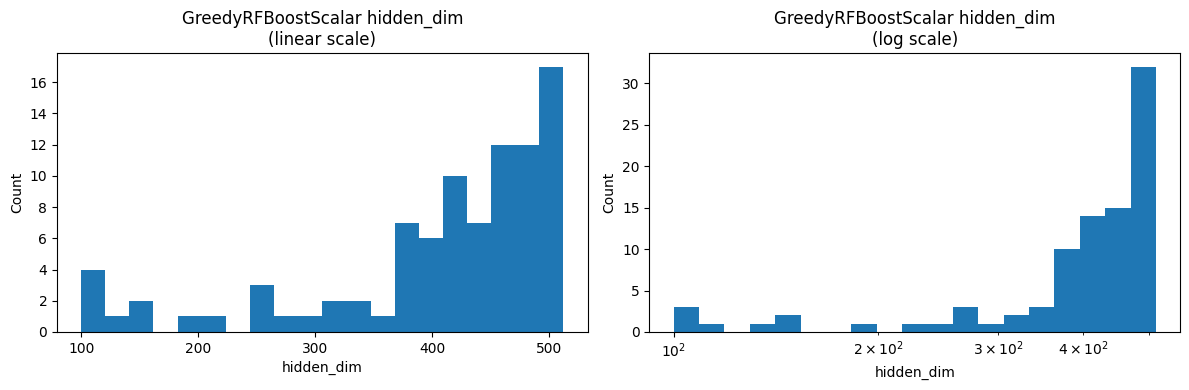

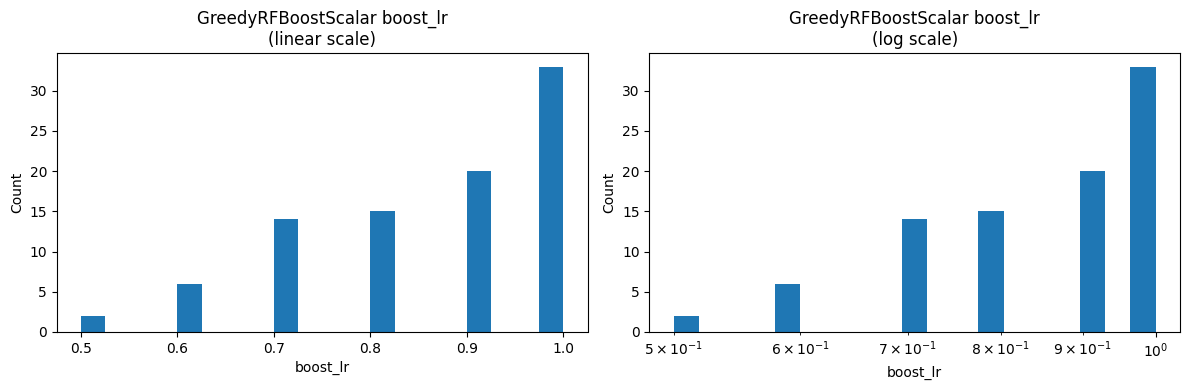

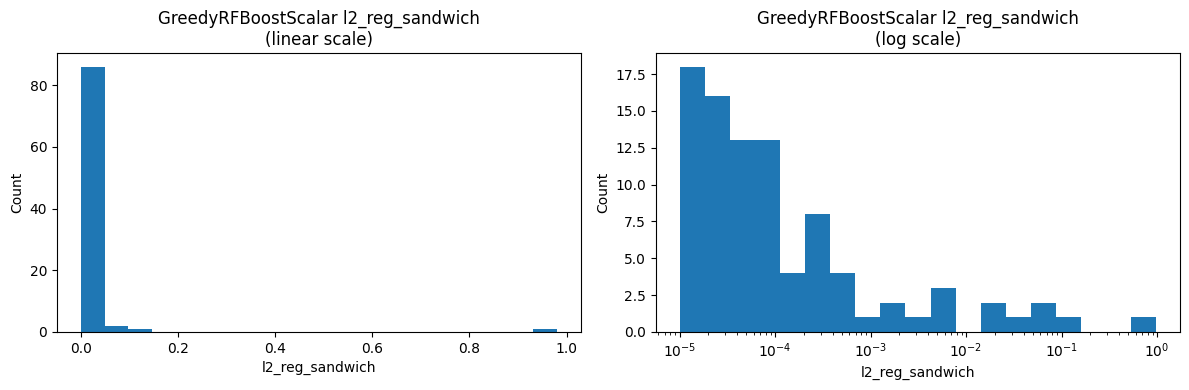

In [61]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = ["End2End", "Ridge", "RidgeCV", "XGBoostRegressor", 
                  "GradientRFBoost", "GradientRFBoostID", 
                  "GreedyRFBoostDense", "GreedyRFBoostDiag", "GreedyRFBoostScalar"],
        datasets = openML_reg_ids_noCat[[0,1,2,3,4,5,6,7,8,9,10,      13,14,15,16,17,18,19]],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale", "sandwich_solver"
                ]:
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()